In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Github/compressai

Mounted at /content/drive
/content/drive/MyDrive/Github/compressai


In [ ]:
!pip install -e .

In [3]:
import cv2
import numpy as np
from PIL import Image
import torch
import os
import pickle
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
import warnings
import struct
import matplotlib.pyplot as plt
import scipy.misc
import array
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [9]:
image = Image.open("dataset/Eval/Images/P1.jpg").convert("RGB")
mask = Image.open("dataset/Eval/Saliency/P1.jpg").convert("L")
#mask = mask.resize((2048,1024))
print(np.asarray(mask).max())

mask = np.asarray(mask)

from torchvision import transforms
mask = torch.from_numpy(mask)

mask = mask.unsqueeze(0)
a = transforms.RandomCrop((256,256))
img_tensor = transforms.PILToTensor()(image)
before_transformation = torch.cat((img_tensor, mask), dim=0)

after_crop = a(before_transformation)

sal_after_crop = after_crop[-1,:,:]
img_after_crop = after_crop[:3,:,:]
img_after_crop = transforms.ToTensor()(transforms.ToPILImage()(img_after_crop))

255


In [10]:
sal_after_crop = sal_after_crop.unsqueeze(0)
torch.cat((img_after_crop, sal_after_crop), dim=0)

tensor([[[  0.5098,   0.5059,   0.4941,  ...,   0.4667,   0.4627,   0.4627],
         [  0.5137,   0.5098,   0.5059,  ...,   0.4667,   0.4627,   0.4627],
         [  0.5216,   0.5216,   0.5216,  ...,   0.4667,   0.4667,   0.4667],
         ...,
         [  0.6863,   0.6784,   0.6863,  ...,   0.2392,   0.2235,   0.4588],
         [  0.6902,   0.6902,   0.6902,  ...,   0.2353,   0.2275,   0.4510],
         [  0.6941,   0.6941,   0.6902,  ...,   0.2392,   0.2314,   0.4275]],

        [[  0.5333,   0.5294,   0.5176,  ...,   0.4902,   0.4863,   0.4863],
         [  0.5451,   0.5412,   0.5373,  ...,   0.4902,   0.4863,   0.4863],
         [  0.5529,   0.5529,   0.5529,  ...,   0.4902,   0.4902,   0.4902],
         ...,
         [  0.8667,   0.8588,   0.8588,  ...,   0.3176,   0.3373,   0.5569],
         [  0.8706,   0.8627,   0.8627,  ...,   0.3255,   0.3490,   0.5373],
         [  0.8667,   0.8667,   0.8627,  ...,   0.3294,   0.3529,   0.5137]],

        [[  0.4863,   0.4824,   0.4706,  ...

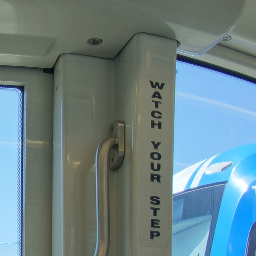

In [12]:
transforms.ToPILImage()(img_after_crop)

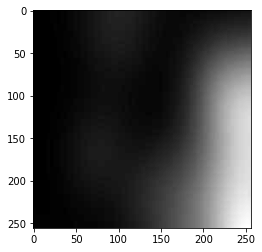

In [14]:
plt.imshow(np.asarray(sal_after_crop[0]),cmap="gray")

In [ ]:
import torch
import torch.nn as nn

mask = Image.open("dataset/Eval/Saliency/P1.jpg").convert("L")
mask_array = np.asarray(mask)/np.max(np.asarray(mask))
#mask_concat = np.stack([mask_array, mask_array, mask_array], axis=-1)
mask = torch.from_numpy(mask_array)
mask = mask.unsqueeze(0)
mask = mask.repeat(3, 1, 1)

input = torch.randn(3,1500, 3000, requires_grad=True)
target = torch.randn(3,1500, 3000)
mse_loss = nn.MSELoss(reduction ="none")
output = mse_loss(input, target)
print(mask.size())
output = (output * mask.float()).sum()

non_zero_elements = mask.sum()
output = output / non_zero_elements

# now doing backpropagation
output.backward()

print(input.size())
print(output.size())
print('output: ', output)

Cheng attention architecture with only Sal-MSE


In [4]:
warnings.filterwarnings('ignore')
!python3 examples/train_saliency.py -m cheng2020-attn -d dataset/ --epochs 100 -lr 1e-4 --batch-size 16 --patch-size 512 1024 --cuda --save --saveloc cheng_attention_salmse  

Downloading: "https://compressai.s3.amazonaws.com/models/v1/cheng2020_attn-mse-3-2d07bbdf.pth.tar" to /root/.cache/torch/hub/checkpoints/cheng2020_attn-mse-3-2d07bbdf.pth.tar
100% 54.3M/54.3M [00:01<00:00, 44.7MB/s]
Learning rate: 0.0001
Train epoch 0: [0/110 (0%)]	Loss: 0.7479 |	MSE loss: 0.0008 |	Bpp loss: 0.21 |	Aux loss: 56.62
Test epoch 0: Average losses:	Loss: 1.0272 |	MSE loss: 0.0010 |	Bpp loss: 0.39 |	Aux loss: 107.12

Learning rate: 0.0001
Train epoch 1: [0/110 (0%)]	Loss: 0.6732 |	MSE loss: 0.0006 |	Bpp loss: 0.28 |	Aux loss: 99.87
Test epoch 1: Average losses:	Loss: 0.9437 |	MSE loss: 0.0009 |	Bpp loss: 0.37 |	Aux loss: 112.46

Learning rate: 0.0001
Train epoch 2: [0/110 (0%)]	Loss: 0.8599 |	MSE loss: 0.0008 |	Bpp loss: 0.33 |	Aux loss: 110.19
Test epoch 2: Average losses:	Loss: 0.9113 |	MSE loss: 0.0008 |	Bpp loss: 0.36 |	Aux loss: 90.56

Learning rate: 0.0001
Train epoch 3: [0/110 (0%)]	Loss: 0.8166 |	MSE loss: 0.0008 |	Bpp loss: 0.30 |	Aux loss: 91.50
Test epoch 3: Avera

Cheng attention architecture with Sal-MSE and ROI Latent masking alpha = 1.5


In [4]:
warnings.filterwarnings('ignore')
!python3 examples/train_saliency.py -m cheng2020-attn -d dataset/ --epochs 100 -lr 1e-4 --batch-size 16 --patch-size 512 1024 --cuda --save --saveloc saved_models

Downloading: "https://compressai.s3.amazonaws.com/models/v1/cheng2020_attn-mse-3-2d07bbdf.pth.tar" to /root/.cache/torch/hub/checkpoints/cheng2020_attn-mse-3-2d07bbdf.pth.tar
100% 54.3M/54.3M [00:01<00:00, 31.0MB/s]
Learning rate: 0.0001
Train epoch 0: [0/110 (0%)]	Loss: 1.1953 |	MSE loss: 0.0014 |	Bpp loss: 0.31 |	Aux loss: 53.16
Test epoch 0: Average losses:	Loss: 0.9970 |	MSE loss: 0.0010 |	Bpp loss: 0.32 |	Aux loss: 166.40

Learning rate: 0.0001
Train epoch 1: [0/110 (0%)]	Loss: 0.5856 |	MSE loss: 0.0005 |	Bpp loss: 0.24 |	Aux loss: 174.39
Test epoch 1: Average losses:	Loss: 0.8896 |	MSE loss: 0.0009 |	Bpp loss: 0.31 |	Aux loss: 137.95

Learning rate: 0.0001
Train epoch 2: [0/110 (0%)]	Loss: 0.5984 |	MSE loss: 0.0005 |	Bpp loss: 0.26 |	Aux loss: 136.93
Test epoch 2: Average losses:	Loss: 0.8482 |	MSE loss: 0.0008 |	Bpp loss: 0.31 |	Aux loss: 94.25

Learning rate: 0.0001
Train epoch 3: [0/110 (0%)]	Loss: 0.4592 |	MSE loss: 0.0004 |	Bpp loss: 0.23 |	Aux loss: 96.37
Test epoch 3: Aver

Cheng attention architecture with Sal-MSE and ROI Latent masking alpha = 1.0 and no sigmoid (lambda = 0.0067)

In [7]:
warnings.filterwarnings('ignore')
!python3 examples/train_saliency.py -m cheng2020-attn -d dataset/ --epochs 150 -lr 1e-4 --batch-size 16 --patch-size 512 1024 --lambda 0.0067 --cuda --save --saveloc saved_models

Downloading: "https://compressai.s3.amazonaws.com/models/v1/cheng2020_attn-mse-3-2d07bbdf.pth.tar" to /root/.cache/torch/hub/checkpoints/cheng2020_attn-mse-3-2d07bbdf.pth.tar
100% 54.3M/54.3M [00:04<00:00, 11.9MB/s]
Learning rate: 0.0001
Train epoch 0: [0/110 (0%)]	Loss: 2.7803 |	MSE loss: 0.0054 |	Bpp loss: 0.43 |	Aux loss: 52.32
Test epoch 0: Average losses:	Loss: 1.4753 |	MSE loss: 0.0026 |	Bpp loss: 0.32 |	Aux loss: 217.78

Learning rate: 0.0001
Train epoch 1: [0/110 (0%)]	Loss: 1.3243 |	MSE loss: 0.0022 |	Bpp loss: 0.35 |	Aux loss: 224.38
Test epoch 1: Average losses:	Loss: 1.1047 |	MSE loss: 0.0017 |	Bpp loss: 0.37 |	Aux loss: 156.24

Learning rate: 0.0001
Train epoch 2: [0/110 (0%)]	Loss: 1.1070 |	MSE loss: 0.0016 |	Bpp loss: 0.40 |	Aux loss: 158.64
Test epoch 2: Average losses:	Loss: 0.9540 |	MSE loss: 0.0015 |	Bpp loss: 0.32 |	Aux loss: 105.06

Learning rate: 0.0001
Train epoch 3: [0/110 (0%)]	Loss: 0.6744 |	MSE loss: 0.0009 |	Bpp loss: 0.26 |	Aux loss: 106.23
Test epoch 3: Av

In [7]:
!python -m compressai.utils.update_model -d saved_models --architecture cheng2020-attn saved_models/checkpoint_best_loss.pth.tar 

In [8]:
!python -m compressai.utils.eval_saliency checkpoint dataset/Eval/Images -a cheng2020-attn -p saved_models/checkpoint_best_loss-3ad3b0f4.pth.tar

Using trained model checkpoint_best_loss-3ad3b0f4-ans
1
bbp  0.11744
PSNR  33.16233825683594
WS-PSNR  32.65488836218736
WS-SSIM  0.890067407358611
SAL-WS-PSNR  31.33904964237798
SAL-PSNR  31.854258465459175
2
bbp  0.294769287109375
PSNR  28.067689895629883
WS-PSNR  27.38645577836209
WS-SSIM  0.7271043229725249
SAL-WS-PSNR  26.268519190170736
SAL-PSNR  27.666343045883842
3
bbp  0.10898
PSNR  34.618167877197266
WS-PSNR  33.972023316895765
WS-SSIM  0.8946537593399366
SAL-WS-PSNR  33.057565225385254
SAL-PSNR  34.185200243376094
4
bbp  0.31022933333333336
PSNR  28.45127296447754
WS-PSNR  27.772494054886696
WS-SSIM  0.7730390915708559
SAL-WS-PSNR  26.88564675721091
SAL-PSNR  27.923294260882358
5
bbp  0.18709159183673468
PSNR  31.987077713012695
WS-PSNR  31.356108877659416
WS-SSIM  0.8468163837445841
SAL-WS-PSNR  30.6252888965142
SAL-PSNR  31.476212876077323
6
bbp  0.07903512967687075
PSNR  35.98339080810547
WS-PSNR  35.3876078661919
WS-SSIM  0.9264773599251822
SAL-WS-PSNR  35.04043575262842


**Evaluation**



Evaluation of Cheng attention with Sal-mse only

In [7]:
!python -m compressai.utils.eval_saliency checkpoint dataset/Eval/Images -a cheng2020-attn -p cheng_attention_salmse/checkpoint_best_loss.pth.tar

Using trained model checkpoint_best_loss-ans
1
bbp  0.15850666666666666
PSNR  34.083099365234375
WS-PSNR  33.56710510467208
WS-SSIM  0.9014054853290917
SAL-WS-PSNR  32.31291256879837
SAL-PSNR  32.79124902213222
2
bbp  0.4133110046386719
PSNR  28.620929718017578
WS-PSNR  27.88278274172946
WS-SSIM  0.7501013255506327
SAL-WS-PSNR  26.744122477246176
SAL-PSNR  28.257780025587355
3
bbp  0.143908
PSNR  35.591087341308594
WS-PSNR  35.073954282563236
WS-SSIM  0.9050012083132408
SAL-WS-PSNR  34.3252325016867
SAL-PSNR  35.25109554798848
4
bbp  0.43648
PSNR  29.28001594543457
WS-PSNR  28.50367081149882
WS-SSIM  0.8048611269859514
SAL-WS-PSNR  27.40601917462957
SAL-PSNR  28.552245859118432
5
bbp  0.2455928163265306
PSNR  32.797183990478516
WS-PSNR  32.12498812670374
WS-SSIM  0.8590136779350771
SAL-WS-PSNR  31.4740988184542
SAL-PSNR  32.40622417108961
6
bbp  0.10204967403628118
PSNR  37.816078186035156
WS-PSNR  37.02254739743542
WS-SSIM  0.9343705965772449
SAL-WS-PSNR  36.45777289686157
SAL-PSNR  3

Evaluation of Cheng attention with latent mask 1.5 and Sal-mse

In [11]:
!python -m compressai.utils.eval_saliency checkpoint dataset/Eval/Images -a cheng2020-attn -p cheng_attention_salmse_latentmask1p5_512_1024_e100/checkpoint_best_loss.pth.tar

Using trained model checkpoint_best_loss-ans
1
bbp  0.13488355555555556
PSNR  33.849117279052734
WS-PSNR  33.21432473520619
WS-SSIM  0.8988858749815528
SAL-WS-PSNR  31.665750827689052
SAL-PSNR  32.227425750384086
2
bbp  0.3255577087402344
PSNR  28.329580307006836
WS-PSNR  27.640953336674862
WS-SSIM  0.7396402593982779
SAL-WS-PSNR  26.466903743541312
SAL-PSNR  27.881801550971105
3
bbp  0.120748
PSNR  35.266937255859375
WS-PSNR  34.58345476809244
WS-SSIM  0.9016010574743097
SAL-WS-PSNR  33.536510499926834
SAL-PSNR  34.651246538142495
4
bbp  0.3591751111111111
PSNR  28.995121002197266
WS-PSNR  28.231673942301857
WS-SSIM  0.796896740492334
SAL-WS-PSNR  27.089488565955804
SAL-PSNR  28.17537301260653
5
bbp  0.2102922448979592
PSNR  32.523929595947266
WS-PSNR  31.807122593711643
WS-SSIM  0.8582004400941696
SAL-WS-PSNR  30.977132798616886
SAL-PSNR  31.925413567775998
6
bbp  0.08745659722222222
PSNR  37.60541534423828
WS-PSNR  36.68309628819457
WS-SSIM  0.9328563963374998
SAL-WS-PSNR  36.089798

Evaluation of pretrained cheng-attn q3

In [9]:
!python -m compressai.utils.eval_saliency pretrained dataset/Eval/Images -a cheng2020-attn -q 3

Downloading: "https://compressai.s3.amazonaws.com/models/v1/cheng2020_attn-mse-3-2d07bbdf.pth.tar" to /root/.cache/torch/hub/checkpoints/cheng2020_attn-mse-3-2d07bbdf.pth.tar
Using trained model cheng2020-attn-mse-3-ans
1
bbp  0.113088
PSNR  33.125709533691406
WS-PSNR  32.49487940370079
WS-SSIM  0.8860662555110412
SAL-WS-PSNR  30.9389821513361
SAL-PSNR  31.493132365516328
2
bbp  0.26837158203125
PSNR  27.92738151550293
WS-PSNR  27.274544233954707
WS-SSIM  0.7227785451310947
SAL-WS-PSNR  26.11954948031459
SAL-PSNR  27.49289768224088
3
bbp  0.10218
PSNR  34.57769775390625
WS-PSNR  33.82295774631081
WS-SSIM  0.8911324795781206
SAL-WS-PSNR  32.75512796472137
SAL-PSNR  33.94367350702235
4
bbp  0.28881066666666666
PSNR  28.451766967773438
WS-PSNR  27.71802914046618
WS-SSIM  0.7676320095976407
SAL-WS-PSNR  26.661564733547067
SAL-PSNR  27.77242627385256
5
bbp  0.17338775510204082
PSNR  31.879581451416016
WS-PSNR  31.158438743713628
WS-SSIM  0.8422688437101371
SAL-WS-PSNR  30.350002997435503
SA

Evaluation of pretrained cheng-attn q4

In [4]:
!python -m compressai.utils.eval_saliency pretrained dataset/Eval/Images -a cheng2020-attn -q 4

Downloading: "https://compressai.s3.amazonaws.com/models/v1/cheng2020_attn-mse-4-f7b0ccf2.pth.tar" to /root/.cache/torch/hub/checkpoints/cheng2020_attn-mse-4-f7b0ccf2.pth.tar
Using trained model cheng2020-attn-mse-4-ans
1
bbp  0.19658666666666666
PSNR  34.943485260009766
WS-PSNR  34.31535262902294
WS-SSIM  0.9140226437327383
SAL-WS-PSNR  32.80589470894439
SAL-PSNR  33.35162204433817
2
bbp  0.4866065979003906
PSNR  29.844345092773438
WS-PSNR  29.28956246659791
WS-SSIM  0.7787320128275916
SAL-WS-PSNR  28.32892485659808
SAL-PSNR  29.589419538718296
3
bbp  0.154624
PSNR  35.93629455566406
WS-PSNR  35.315740343319504
WS-SSIM  0.9088312697447029
SAL-WS-PSNR  34.42047710479005
SAL-PSNR  35.455014776115924
4
bbp  0.533696
PSNR  30.58747673034668
WS-PSNR  29.891054531567146
WS-SSIM  0.8432346199610082
SAL-WS-PSNR  29.041369859827824
SAL-PSNR  30.102623928925254
5
bbp  0.2811402448979592
PSNR  33.56659698486328
WS-PSNR  32.91866412813335
WS-SSIM  0.8741934966563026
SAL-WS-PSNR  32.31532726005427